In [54]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa import seasonal
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima import model

## Load in data

In [86]:
all_occupancy_df = pd.read_csv(
    r"../../output/descriptive_analysis.csv",
    usecols=["dates", "occupancy"],
    parse_dates=["dates"],
)

all_occupancy_df

,dates,occupancy
0,2017-04-01,30
1,2017-04-02,45
2,2017-04-03,65
3,2017-04-04,76
4,2017-04-05,71
...,...,...
748,2019-04-19,1
749,2019-04-20,1
750,2019-04-21,1
751,2019-04-22,1


In [87]:
all_occupancy_df.head()

,dates,occupancy
0,2017-04-01,30
1,2017-04-02,45
2,2017-04-03,65
3,2017-04-04,76
4,2017-04-05,71


## Remove anomaly in data at beginning and end

In [88]:
START_DAY = datetime.datetime(day=1, month=6, year=2017)
END_DAY = datetime.datetime(day=1, month=6, year=2018)
filter_bad_data = (all_occupancy_df["dates"] >= START_DAY) & (
    all_occupancy_df["dates"] <= END_DAY
)
occupancy_df = all_occupancy_df.loc[filter_bad_data]
occupancy_df.index.freq = "D"
occupancy_df

,dates,occupancy
61,2017-06-01,115
62,2017-06-02,113
63,2017-06-03,112
64,2017-06-04,117
65,2017-06-05,132
...,...,...
422,2018-05-28,103
423,2018-05-29,108
424,2018-05-30,104
425,2018-05-31,107


## Visualize Filtered Dataset

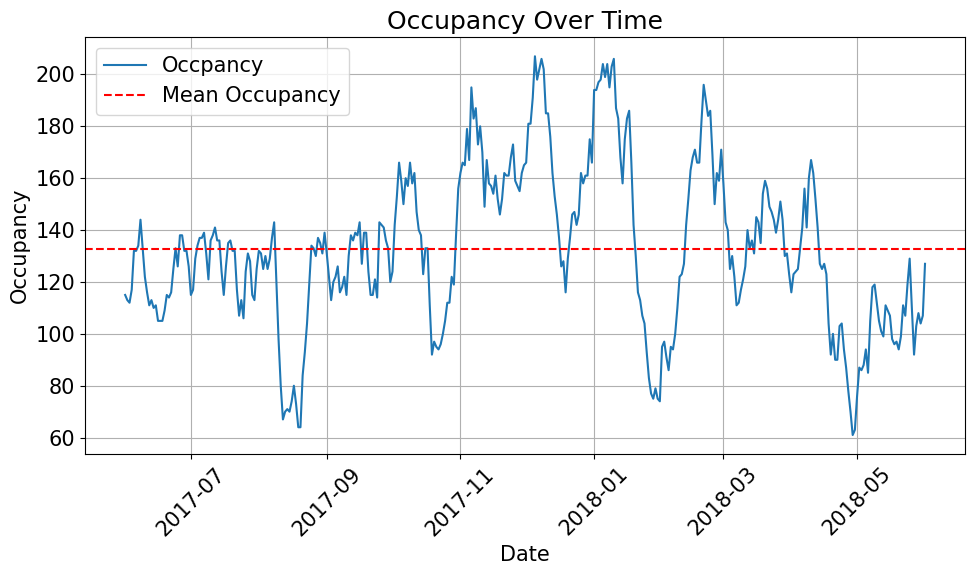

In [89]:
mean = occupancy_df["occupancy"].mean()

plt.figure(figsize=(10, 6))
plt.plot(
    occupancy_df["dates"], occupancy_df["occupancy"], linestyle="-", label="Occpancy"
)
plt.title("Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.axhline(y=mean, color="red", linestyle="--", label="Mean Occupancy")
plt.legend()
plt.show()

## STL decomposition (Season-trend)

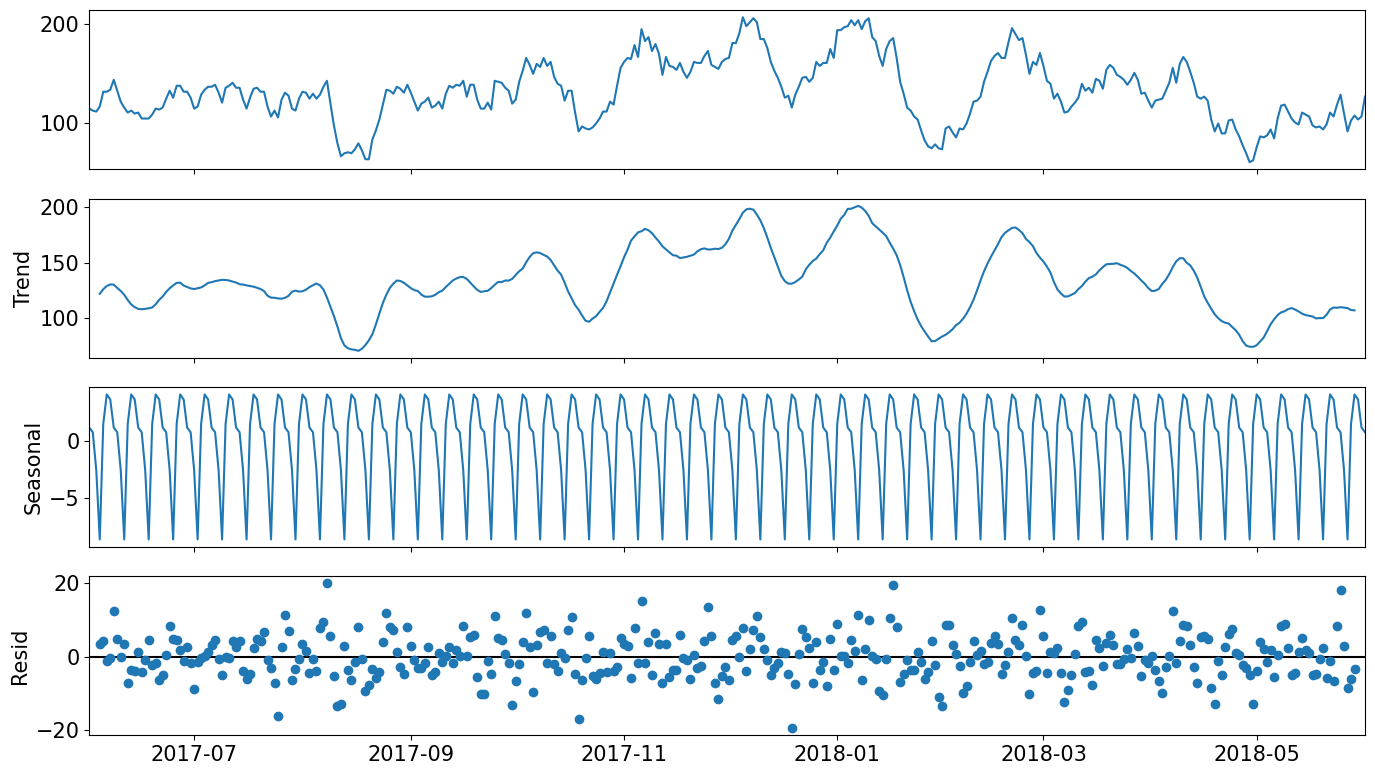

In [90]:
plt.rc("figure", figsize=(14, 8))
plt.rc("font", size=15)

result = seasonal.seasonal_decompose(occupancy_df.set_index("dates"), model="additive")
fig = result.plot()

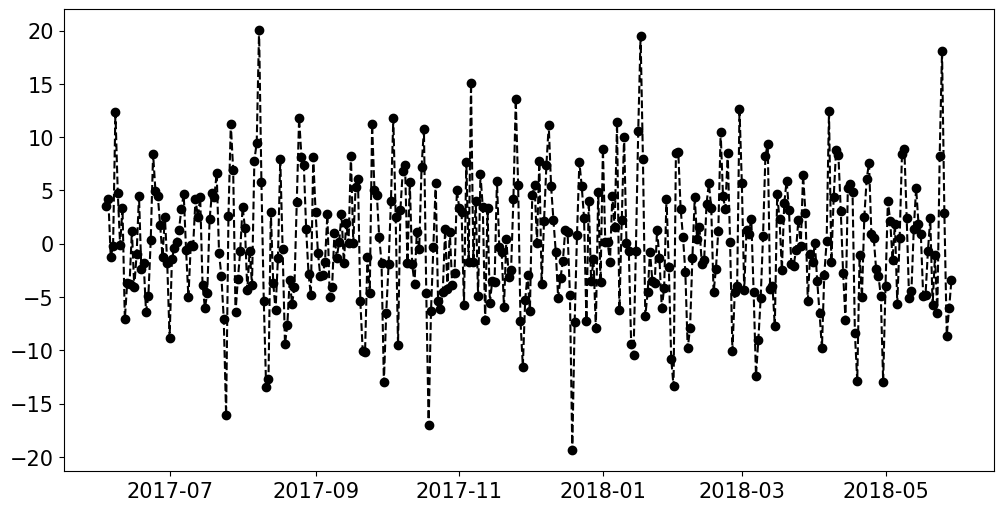

In [91]:
plt.rc("figure", figsize=(12, 6))
plt.rc("font", size=15)
fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color="black", linestyle="--")
# ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
#           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
# fig.autofmt_xdate()
plt.show()

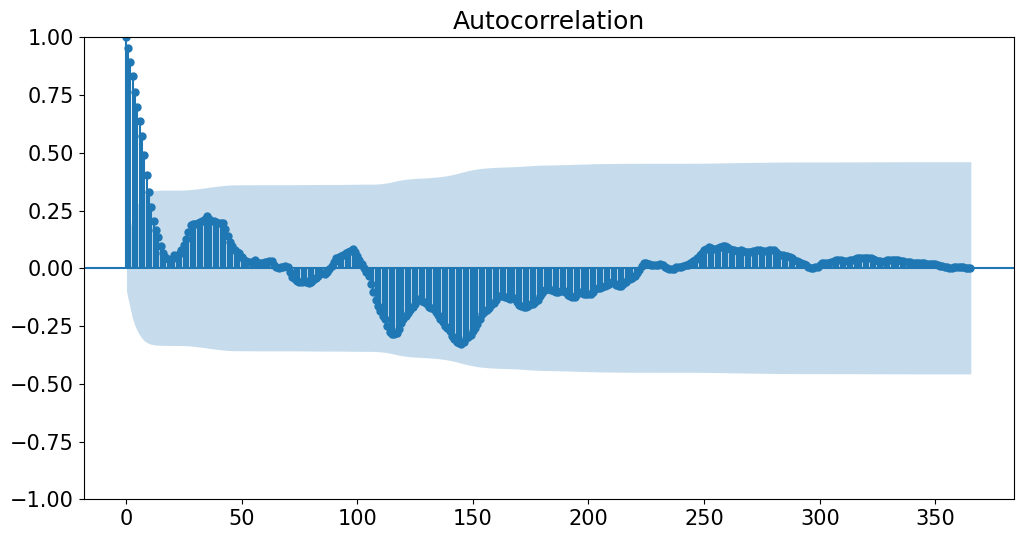

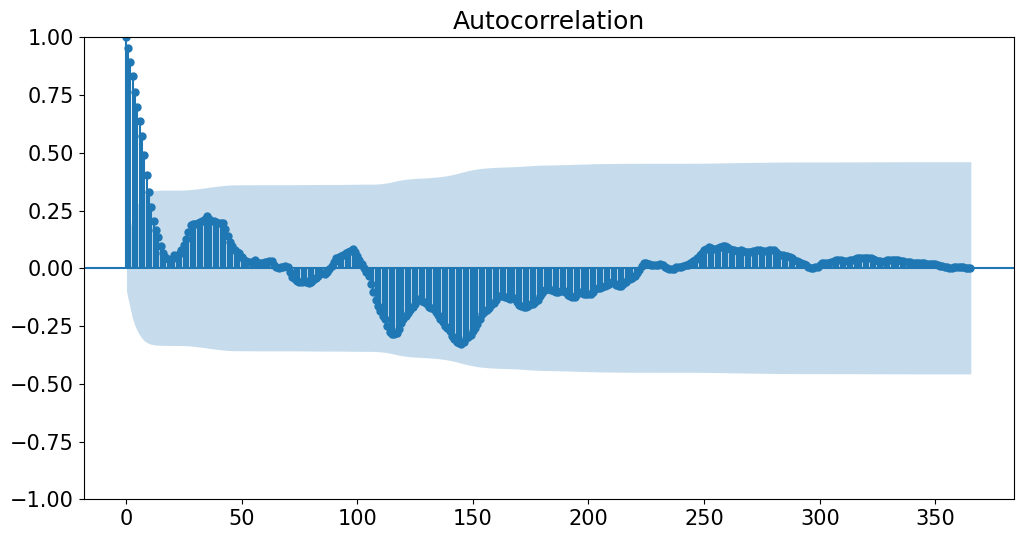

In [92]:
tsaplots.plot_acf(occupancy_df.set_index("dates"), lags=365)
# lags: number of 'periods' you will like to investigate

In [93]:
def check_stationarity(df):
    dftest = stattools.adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]["5%"]
    if (pvalue < 0.05) and (adf < critical_value):
        print("The series is stationary")
    else:
        print("The series is NOT stationary")


check_stationarity(occupancy_df.set_index("dates"))

The series is stationary


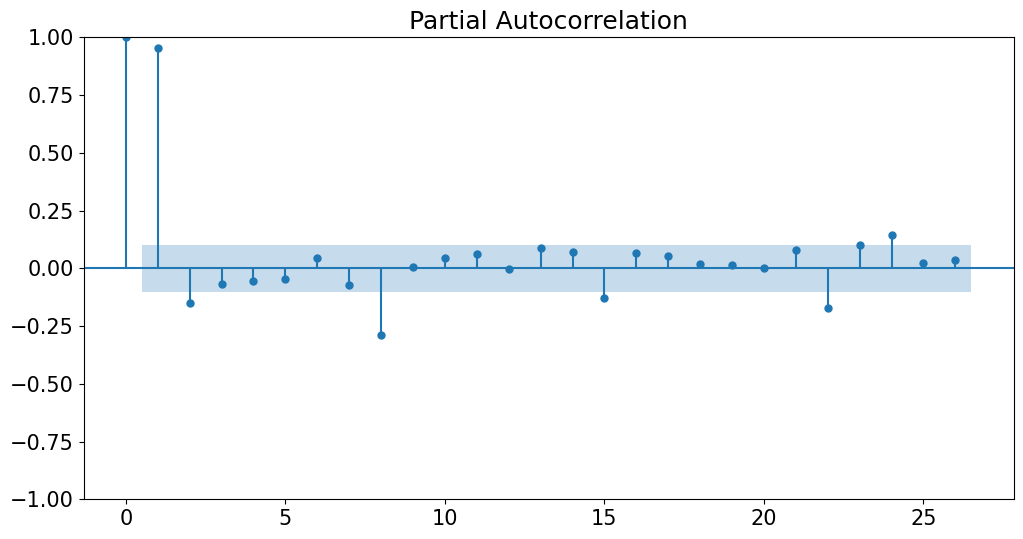

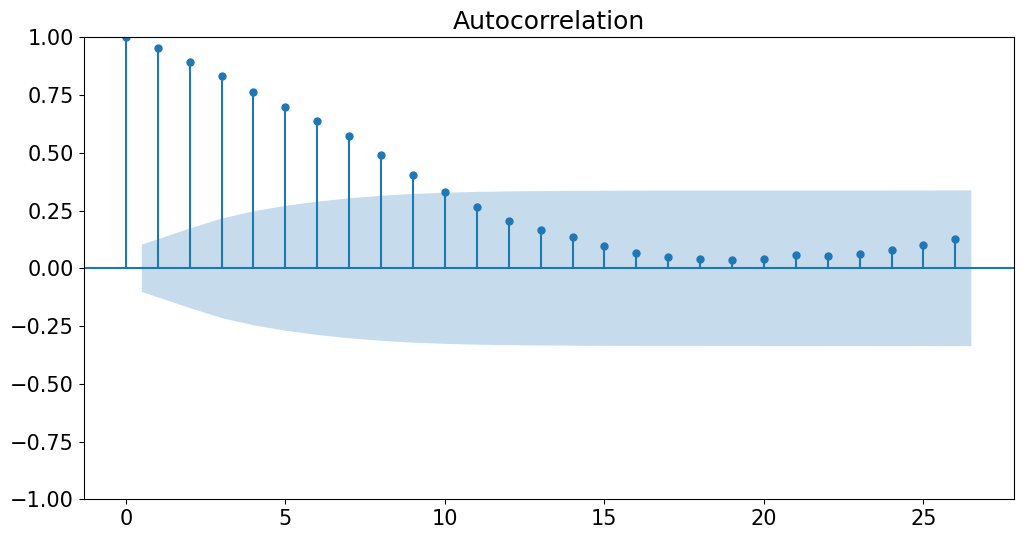

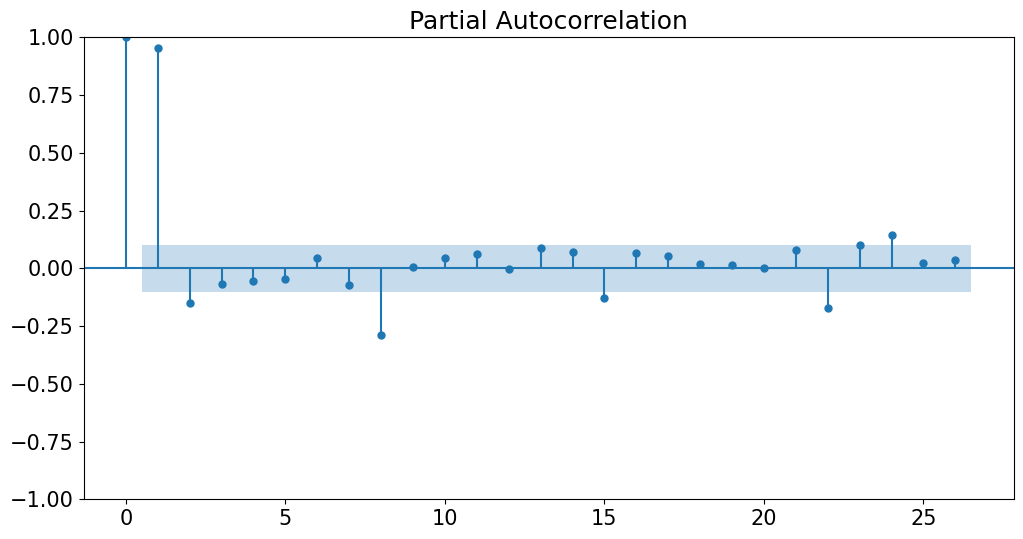

In [94]:
tsaplots.plot_acf(occupancy_df["occupancy"])
tsaplots.plot_pacf(occupancy_df["occupancy"])

In [95]:
# Import the library
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings

warnings.filterwarnings("ignore")

# Fit auto_arima function to occupancy dataset
stepwise_fit = auto_arima(
    occupancy_df["occupancy"],
    start_p=1,
    start_q=1,
    max_p=3,
    max_q=3,
    m=7,
    start_P=0,
    seasonal=True,
    d=None,
    D=1,
    trace=True,
    error_action="ignore",  # we don't want to know if an order does not work
    suppress_warnings=True,  # we don't want convergence warnings
    stepwise=True,
)  # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=4.25 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3434.621, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=2716.244, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3092.060, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3432.658, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=2773.479, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=2665.611, Time=1.09 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=3365.015, Time=0.81 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=2644.185, Time=1.46 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=2694.128, Time=0.82 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=2.88 sec
 ARIMA(3,0,0)(2,1,0)[7] intercept   : AIC=2627.707, Time=2.00 sec
 ARIMA(3,0,0)(1,1,0)[7] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  366
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 7)   Log Likelihood               -1298.288
Date:                            Mon, 22 Apr 2024   AIC                           2608.577
Time:                                    10:18:17   BIC                           2631.877
Sample:                                         0   HQIC                          2617.842
                                            - 366                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8998      0.029     65.329      0.000       1.843       1.957
ar.L2         -0.9258      0.027    -34.483      0.000      -0.978      -0.873
ma.L1         -0.8456      0.048    -17.462      0.000      -0.941      -0.751
ar.S.L7       -0.6130      0.052    -11.775      0.000      -0.715      -0.511
ar.S.L14      -0.3505      0.055     -6.349      0.000      -0.459      -0.242
sigma2        79.6959      6.228     12.796      0.000      67.489      91.902
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.81   Prob(JB):                         0.73
Heteroskedasticity (H):               1.14   Skew:                             0.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
# Fit a ARIMA(2,0,1)(2,1,0)[7] on the training set

occupancy_with_date_as_index_df = occupancy_df.set_index("dates")

# Split data into train / test sets
train = occupancy_with_date_as_index_df.iloc[
    : len(occupancy_with_date_as_index_df) - 30
]
test = occupancy_with_date_as_index_df.iloc[
    len(occupancy_with_date_as_index_df) - 30 :
]  # set one year(12 months) for testing


m = model.ARIMA(train["occupancy"], order=(2, 0, 1), seasonal_order=(2, 1, 0, 7))

result = m.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        occupancy   No. Observations:                  336
Model:             ARIMA(2, 0, 1)x(2, 1, [], 7)   Log Likelihood               -1190.647
Date:                          Mon, 22 Apr 2024   AIC                           2393.294
Time:                                  10:19:18   BIC                           2416.071
Sample:                              06-01-2017   HQIC                          2402.380
                                   - 05-02-2018                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9074      0.029     65.520      0.000       1.850       1.965
ar.L2         -0.9332      0.027    -34.424      0.000      -0.986      -0.880
ma.L1         -0.8453      0.049    -17.343      0.000      -0.941      -0.750
ar.S.L7       -0.6277      0.054    -11.619      0.000      -0.734      -0.522
ar.S.L14      -0.3633      0.058     -6.278      0.000      -0.477      -0.250
sigma2        79.9097      6.606     12.097      0.000      66.963      92.856
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.90   Prob(JB):                         0.70
Heteroskedasticity (H):               1.37   Skew:                             0.09
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

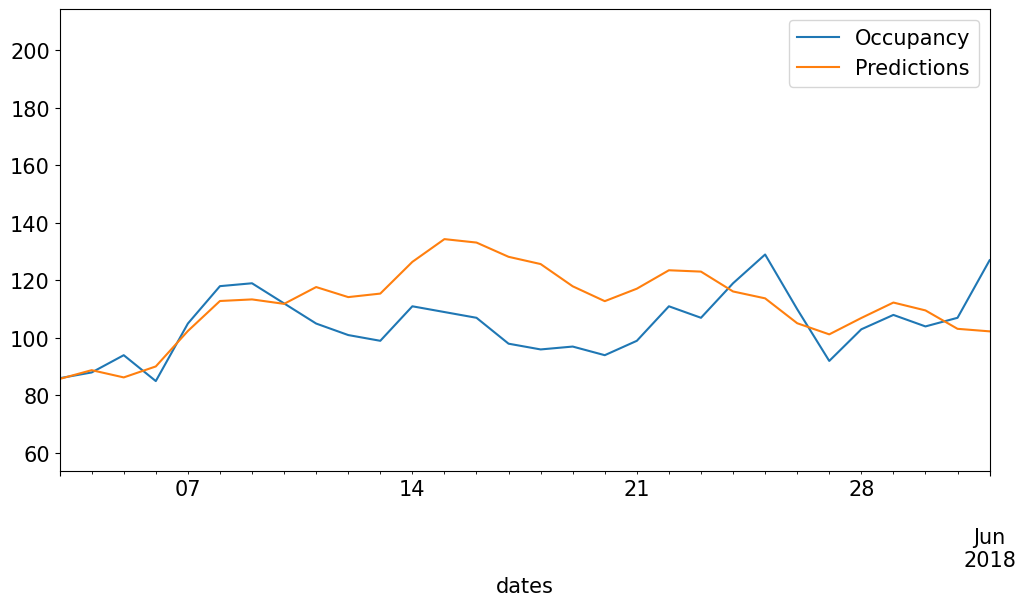

In [108]:
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end, typ="levels").rename("Predictions")

# Plot occupancy data
occupancy_with_date_as_index_df.plot(legend=True)

# Plot predictions for the last 30 days
predictions_last_30_days = predictions.tail(30)
predictions_last_30_days.plot(legend=True)

# Add legend
plt.legend(["Occupancy", "Predictions"])

# Set x-axis limits to the last 30 days
plt.xlim(
    occupancy_with_date_as_index_df.index[-30],
    occupancy_with_date_as_index_df.index[-1],
)

# Show the plot
plt.show()

In [109]:
arima = model.ARIMA(occupancy_df["occupancy"], order=(32, 0, 1))
model_fit = arima.fit()
model_fit.summary()
predictions = model_fit.predict()
predictions.index = occupancy_df["dates"]

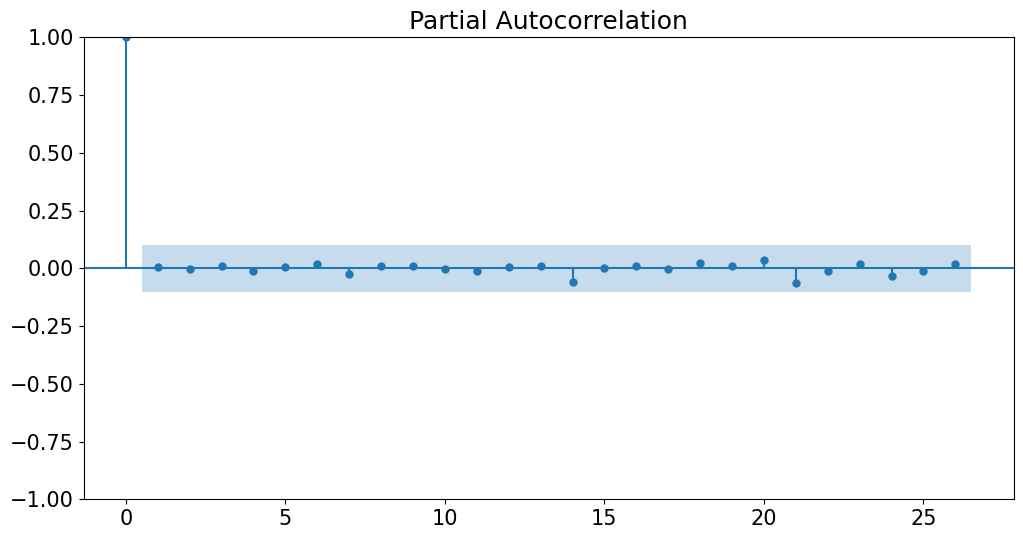

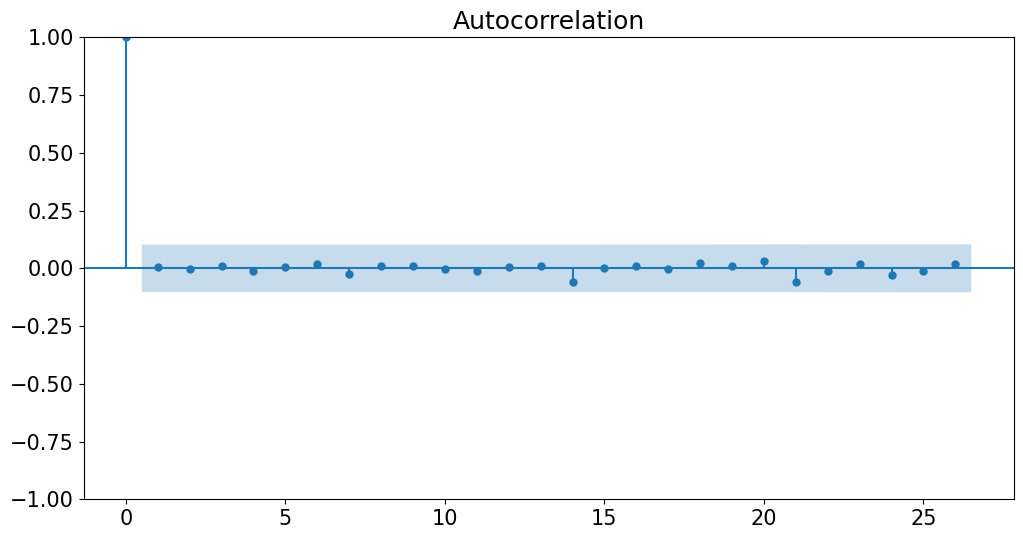

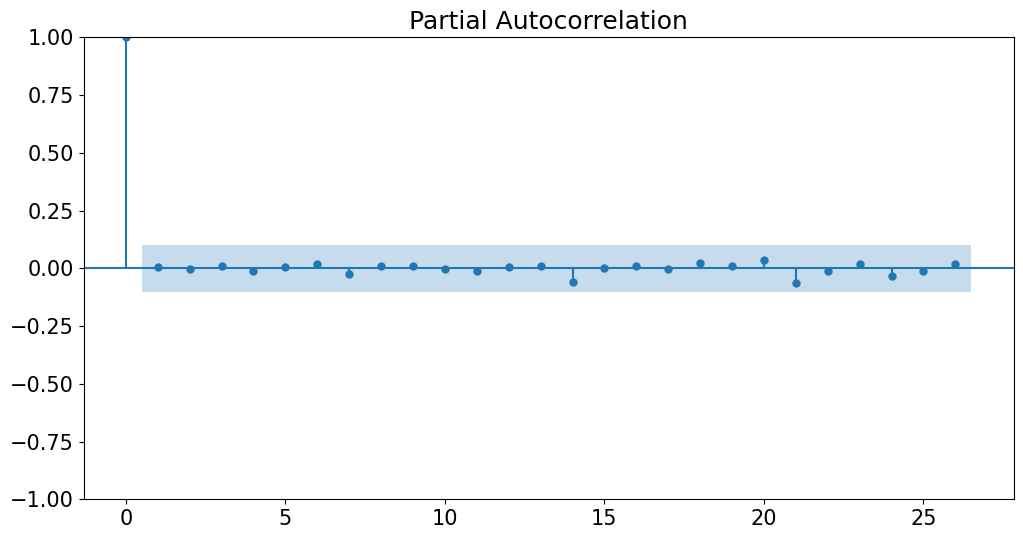

In [110]:
residuals = pd.DataFrame(model_fit.resid)
tsaplots.plot_acf(residuals)
tsaplots.plot_pacf(residuals)

<Axes: >

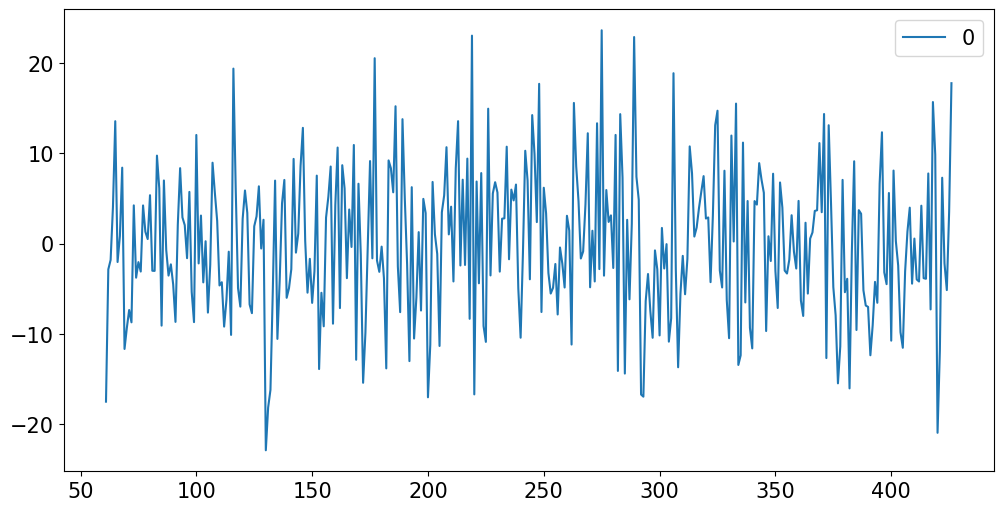

In [111]:
residuals.plot()

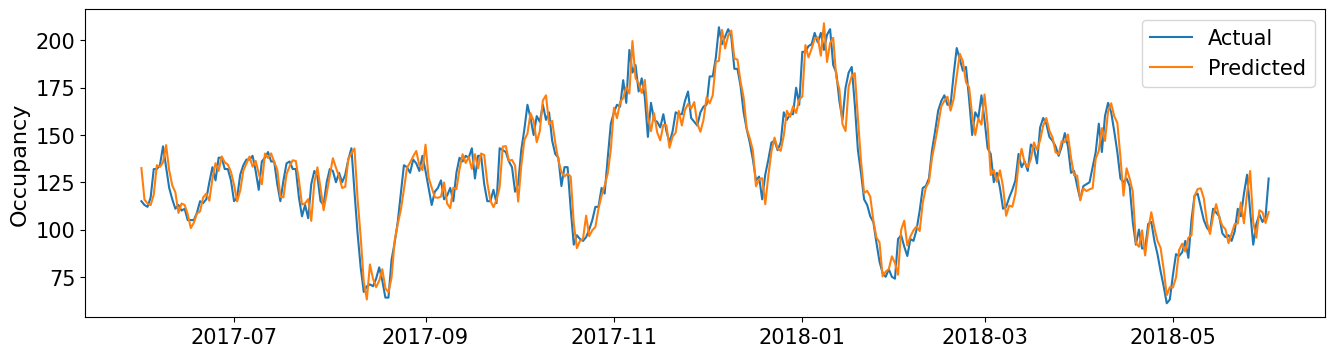

In [112]:
plt.figure(figsize=(16, 4))
plt.plot(
    occupancy_df.set_index("dates"), label="Actual"
)  # No diff because we are working with stationary data
plt.plot(predictions, label="Predicted")
plt.ylabel("Occupancy", fontsize=16)
plt.legend()

---

In [113]:
result = stattools.adfuller(occupancy_df.occupancy.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -3.5016123303739453
p-value: 0.007945782425388867


p - Wert < 0.05 &rarr; Daten sind stationär

In [114]:
from pmdarima import arima

stepwise_fit = arima.auto_arima(occupancy_df["occupancy"], trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2688.532, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2686.449, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2683.178, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2683.567, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2684.454, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2684.718, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2684.561, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2686.533, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2681.183, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2682.723, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2682.566, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2681.572, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2684.539, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.139 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1338.591
Date:                Mon, 22 Apr 2024   AIC                           2681.183
Time:                        10:24:08   BIC                           2688.983
Sample:                             0   HQIC                          2684.283
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1203      0.049      2.473      0.013       0.025       0.216
sigma2        89.7312      6.732     13.330      0.000      76.537     102.925
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.94   Prob(JB):                         0.32
Heteroskedasticity (H):               1.19   Skew:                             0.19
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
train = occupancy_df.iloc[:-30]
test = occupancy_df.iloc[-30:]
print(train.shape, test.shape)

(336, 2) (30, 2)


In [116]:
m = model.ARIMA(train["occupancy"], order=(1, 1, 0))
m = m.fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              occupancy   No. Observations:                  336
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1228.372
Date:                Mon, 22 Apr 2024   AIC                           2460.744
Time:                        10:24:09   BIC                           2468.373
Sample:                             0   HQIC                          2463.785
                                - 336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1232      0.051      2.422      0.015       0.023       0.223
sigma2        89.6245      6.989     12.823      0.000      75.925     103.324
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.88   Prob(JB):                         0.31
Heteroskedasticity (H):               1.35   Skew:                             0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
start = len(train)
end = len(train) + len(test) - 1

pred = m.predict(start=start, end=end, typ="levels")
pred.index = occupancy_df.index[start : end + 1]
pred

397    88.354846
398    88.521719
399    88.542273
400    88.544804
401    88.545116
402    88.545154
403    88.545159
404    88.545160
405    88.545160
406    88.545160
407    88.545160
408    88.545160
409    88.545160
410    88.545160
411    88.545160
412    88.545160
413    88.545160
414    88.545160
415    88.545160
416    88.545160
417    88.545160
418    88.545160
419    88.545160
420    88.545160
421    88.545160
422    88.545160
423    88.545160
424    88.545160
425    88.545160
426    88.545160
Name: predicted_mean, dtype: float64